In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [192]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import circle_dataset
import digit_dataset
import train
import os

In [197]:
if os.path.exists("digit_dataset.npy"):
    examples = np.load("digit_dataset.npy")
else:
    examples = np.array(digit_dataset.dataset((64, 64, 3), 4, 1, 100000))
    examples = (examples * 255.0).astype(np.uint8)
    np.save("digit_dataset.npy", examples)

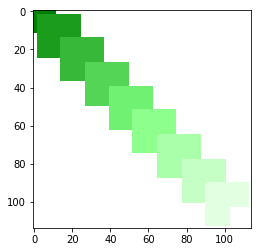

In [195]:
m = circle_dataset.draw_picture(
    [(i, i, 0.1, (i * 255, min(255, 128 + i * 255), min(255, i * 255)), "rectangle") for i in np.linspace(0, 1.0, 10)], (114,114,3));
plt.imshow(m)

/usr/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


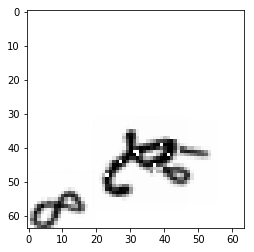

In [222]:
figsize = examples.shape[1:]
tf.reset_default_graph()
session = tf.InteractiveSession()
m = train.build_model(figsize,
                      filters=32,
                      kernel_size=3,
                      hidden_sizes=[50],
                      lstm_size=50,
                      lr=0.0001,
                      fixed_sprites=False,
                      num_sprites=50,
                      decoder="rnn",
                      max_steps=5)

session.run(tf.global_variables_initializer())
max_iterations = 200000
running_loss = None
alpha = 0.99
batch_size = 64
example_indices = np.arange(len(examples))
val_example = examples[np.random.randint(0, len(examples))][None]
plt.imshow((val_example[0]).astype(np.uint8))

In [223]:
def drawfigs(save=True, close=True, savedir="samples"):
    os.makedirs(savedir, exist_ok=True)
    val_example_indices = list(range(20))
    gstep, out = session.run([m.global_step, m.outputs[0]], feed_dict={m.inputs[0]: np.stack([examples[ex] for ex in val_example_indices], axis=0),
                                               m.max_steps: 5})
    fig, ax = plt.subplots(nrows=2, ncols=len(val_example_indices), sharex=True, sharey=True,
                           figsize=(1 * len(val_example_indices), 2))
    for i, ex in enumerate(val_example_indices):
        ax[0, i].set_axis_off()
        ax[1, i].set_axis_off()
        ax[0, i].imshow(examples[ex])
        ax[1, i].imshow(out[i])
    plt.axis('off');
    if save:
        plt.savefig("%s/%d-figs.png" % (savedir, gstep,))
    if close:
        plt.close(fig)

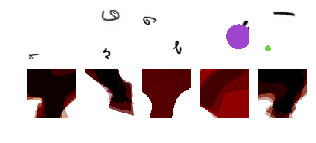

In [224]:
val_example_indices = [1000, 1001, 1002, 1004, 1010]
gstep, out = session.run([m.global_step, m.outputs[0]], feed_dict={m.inputs[0]: np.stack([examples[ex] for ex in val_example_indices], axis=0),
                                           m.max_steps: 5})
fig, ax = plt.subplots(nrows=2, ncols=len(val_example_indices), sharex=True, sharey=True,
                       figsize=(1 * len(val_example_indices), 2))
for i, ex in enumerate(val_example_indices):
    ax[0, i].set_axis_off()
    ax[1, i].set_axis_off()
    ax[0, i].imshow(examples[ex])
    ax[1, i].imshow(out[i])

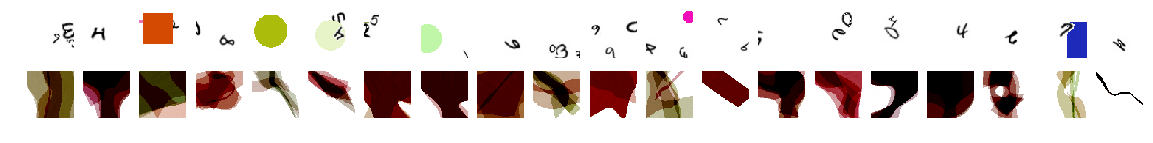

In [225]:
drawfigs(save=False, close=False)

In [ ]:
for i in range(max_iterations):
    batch = np.stack([examples[idx] for idx in np.random.choice(example_indices, size=min(len(examples), batch_size), replace=False)],
                     axis=0)
    loss, _, gnorm = session.run([m.loss, m.train_op, m.grad_norm], feed_dict={
        m.inputs[0]: batch, m.training: True, m.max_steps: 5})
    if running_loss is None:
        running_loss = loss
    else:
        running_loss = alpha * running_loss + (1.0 - alpha) * loss
    if i % 100 == 0:
        print("%d, %.3f (%.3f) %.3f" % (i, running_loss, loss, gnorm))
    if i % 1000 == 0:
        drawfigs(savedir="samples_digits")

0, 239.230 (239.230) 76.247
100, 238.804 (238.029) 211.314
200, 238.604 (241.343) 814.472
300, 238.460 (241.675) 221.376
400, 238.364 (239.641) 293.796
500, 238.676 (240.398) 590.043
600, 238.584 (239.773) 569.842
700, 238.461 (239.114) 351.919
800, 238.313 (236.378) 500.426
